Import libraries

In [60]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, \
    StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report
def my_boxplot(data, labels, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(data)
    ax.set_xticklabels(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def my_lineplot(x, ylist, yLabelList, xlabel, ylabel):
    '''ylist: list of all y'''
    for y,label in zip(ylist,yLabelList):
        plt.plot(x, y, '-o', label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

Prepare the dataset

In [3]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'

## 1. Data Exploring

In [4]:
data.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### 1.1. Determine Numerical and Categorical Features

In [5]:
# number of unique values in each column
n_uniques = data.nunique()
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("CATEGORICAL:", categorical_ix)
print("NUMERICAL  :", numerical_ix)

CATEGORICAL: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
NUMERICAL  : ['age', 'avg_glucose_level', 'bmi']


### 1.2. Visualize the data

In [6]:
variables = [variable for variable in data.columns if variable not in ['id','stroke']]
conts = ['age','avg_glucose_level','bmi']
background_color = "#fafafa"

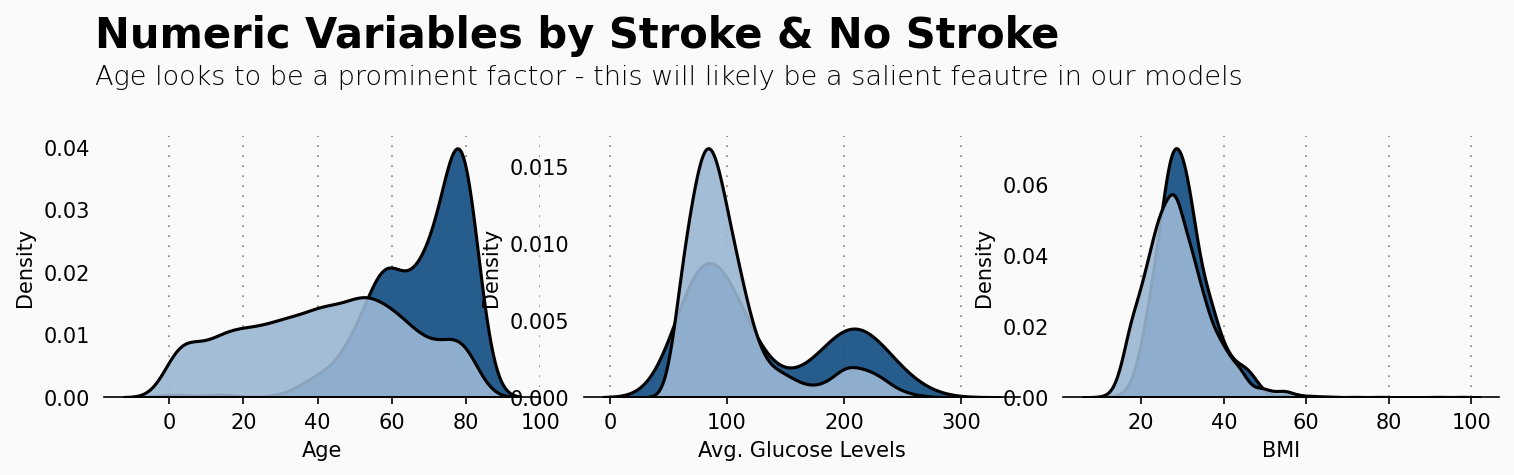

In [7]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = data[data['stroke'] == 1]
ns = data[data['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models',
         fontsize=13, fontweight='light')

plt.show()

## 2. Data preprocessing

### 2.1. Handle outlier

In [8]:
# TODO
data = data[data['gender'] != "Other"]

### 2.2. Handle missing data

In [9]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


The dataset had 201 samples with missing BMI value. Instead of
imputing it naively with the mean or the median, we used a simple **decision
tree model** to predict that based on gender and age.

In [10]:
DT_bmi_pipe = Pipeline([('scale',StandardScaler()),
                         ('lr',DecisionTreeRegressor(random_state=42))
                         ])
X = data[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1})
missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
y = X.pop('bmi')
DT_bmi_pipe.fit(X,y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing[['age','gender']]),index=missing.index)
data.loc[missing.index,'bmi'] = predicted_bmi
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### 2.3. Encode Categorial Features
Before encoding, we will split the data set

In [11]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)
scoring = 'f1'
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=42)

SVM requires that each data instance is represented as a vector of real numbers.
Hence, if there are categorical attributes, we first have to convert them into numeric
data. There are 2 numerical types that can be converted to from categorical data: Ordinal or Nominal.

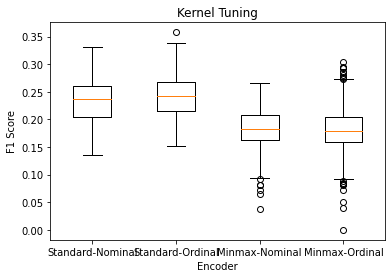

In [137]:
transformers = [('Standard-Nominal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                             remainder='passthrough')),
               ('Standard-Ordinal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                             remainder='passthrough')),
               ('Minmax-Nominal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                    ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                                   remainder='passthrough')),
                ('Minmax-Ordinal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                      ('encode', OrdinalEncoder(), categorical_ix)],
                                                     remainder='passthrough'))
                ]
results = {'Standard-Nominal':[], 'Standard-Ordinal':[], 'Minmax-Nominal':[],'Minmax-Ordinal':[]}
for _ in range(50):
    for name, transformer in transformers:
        model = Pipeline([(name, transformer),
                          ('Random Undersampling',RandomUnderSampler(sampling_strategy=0.4)),
                          ('SVC', SVC())])
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, error_score='raise', n_jobs=-1)
        results[name].extend(cv_results)

my_boxplot(list(results.values()),list(results.keys()),"Encoder", "F1 Score", "Kernel Tuning")

If we don't use SMOTE before SVC, the nominal encode give us a higher score. But when we use SMOTE, the better score is ordinal.
Because later we'll use SMOTE to handle imbalanced data, we will choose ordinal encode for categorical data.

In [13]:
transformer = ColumnTransformer([('StandardScaler', StandardScaler(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

### 2.3. Handle imbalance
First we will compare different sampling method of over-sampling, under-sampling and a combination of those. Our candidates are:
- SMOTE (oversampling)
- Random Oversampling
- Random Undersampling
- SMOTE and Edited Nearest Neighbors (combination of over- and under-)

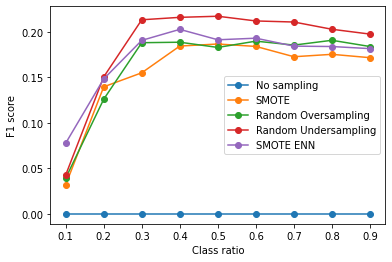

In [14]:
ratios = np.arange(0.1, 0.91, 0.1)
svc_model = SVC(C=10)

imb_scores = [[]]
samplers_scores = [[],[],[],[]]
samplers = [('SMOTE',SMOTE(random_state=42)),
            ('Random Oversampling',RandomOverSampler(random_state=42)),
            ('Random Undersampling',RandomUnderSampler(random_state=42)),
            ('SMOTE ENN',SMOTEENN(random_state=42))
            ]

for rate in ratios:
    imb_model = Pipeline([('Trans', transformer), ('SVC', svc_model) ])
    imb_results = cross_val_score(imb_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
    imb_scores[0].append(imb_results.mean())
    for sampler, sampler_score in zip(samplers,samplers_scores):
        sampler[1].set_params(sampling_strategy=rate)
        sampling_model = Pipeline([('Trans', transformer),
                                ('Sampler', sampler[1]),
                                ('SVC', svc_model)
                                ])
        results = cross_val_score(sampling_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
        sampler_score.append(results.mean())

# Line plots
my_lineplot(x=ratios,
            ylist=imb_scores + samplers_scores,
            yLabelList=['No sampling'] + [sampler[0] for sampler in samplers],
            xlabel='Class ratio', ylabel='F1 score')

We can observe that random under sampling has the highest score. I will try to compare it with other under-sampling methods like:
- Neighborhood cleaning rule
- Tomek Links
- ENN

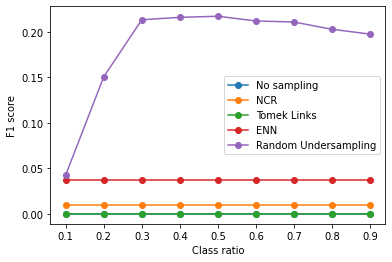

In [15]:
under_samplers_scores = [[],[],[]]
under_samplers = [('NCR',NeighbourhoodCleaningRule()),
            ('Tomek Links',TomekLinks()),
            ('ENN', EditedNearestNeighbours())
            ]

for rate in ratios:
    for sampler, sampler_score in zip(under_samplers,under_samplers_scores):
        sampling_model = Pipeline([('Trans', transformer),
                                   ('Sampler', sampler[1]),
                                   ('SVC', svc_model)
                                   ])
        results = cross_val_score(sampling_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
        sampler_score.append(results.mean())
my_lineplot(x=ratios,
            ylist=imb_scores + under_samplers_scores + [samplers_scores[2]],
            yLabelList=['No sampling'] + [sampler[0] for sampler in under_samplers] + [samplers[2][0]],
            xlabel='Class ratio', ylabel='F1 score')

From the experiments, we conclude that the Random Undersampling methods is the most suitable for the SVM model.

In [16]:
sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=42)

## 3. Enhance the algorithm
Tuning the estimator using Cross-validation and Grid-search

Choosing the best kernel

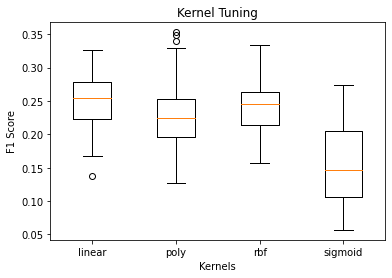

In [75]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {'linear':[], 'poly':[], 'rbf':[], 'sigmoid':[]}
for _ in range(50):
    for kernel in results:
        kernel_model = Pipeline([('Trans',transformer),
                                 ('Sampler',RandomUnderSampler(sampling_strategy=0.4)),
                                 ('SVC',SVC(kernel=kernel))
                                 ])
        cv_results = cross_val_score(kernel_model, X_train, y_train, cv=kfold, scoring=scoring)
        results[kernel].extend(cv_results)
my_boxplot(list(results.values()),kernels,"Kernels", "F1 Score", "Kernel Tuning")

Parameter chosen range:
- Kernel: RBF
- C (penalty parameter): $$10^{-15} \to 10^{1}$$
- Gamma (kernel parameter): $$10^{-5} \to 10^{15}$$

the parameters {'SVC__C': 1, 'SVC__gamma': 0.125} are the best.


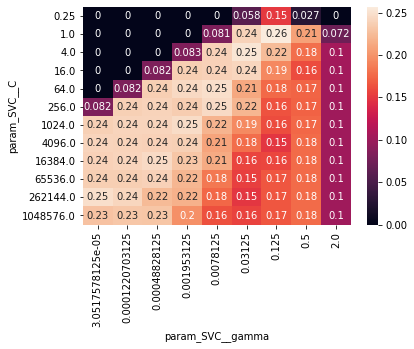

In [99]:
tune_model = Pipeline([
    ('Trans',transformer),
    ('Sampler',sampler),
    ('SVC', SVC())
])

# Set the parameters
tuned_parameters = [{'SVC__gamma': [2**x for x in range(-15,2,2)],
                     'SVC__C' : [2**x for x in range(-2,21,2)]}]
GS1 = GridSearchCV(estimator=tune_model, param_grid=tuned_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS1.fit(X_train, y_train)
result = pd.pivot_table(pd.DataFrame(GS1.cv_results_),values='mean_test_score',
                        columns='param_SVC__gamma',index='param_SVC__C')
sns.heatmap(result,annot=True)
print("the parameters {} are the best.".format(GS1.best_params_))

Finner Grid search

the parameters {'SVC__C': 1, 'SVC__gamma': 0.125} are the best.


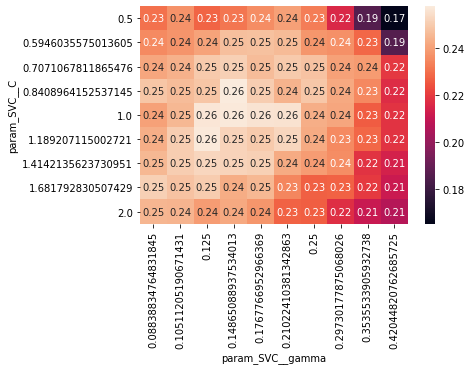

In [101]:
# Set the parameters
finner_parameters = [{'SVC__gamma': [2**x for x in np.arange(-3.5,-1,0.25)],
                     'SVC__C' : [2**x for x in np.arange(-1,1.25,0.25)]
                     }]
GS2 = GridSearchCV(estimator=tune_model, param_grid=finner_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS2.fit(X_train, y_train)
result2 = pd.pivot_table(pd.DataFrame(GS2.cv_results_),values='mean_test_score',
                        columns='param_SVC__gamma',index='param_SVC__C')
sns.heatmap(result2,annot=True)
print("the parameters {} are the best.".format(GS1.best_params_))

Parameter chosen range:
- Kernel: linear
- C (penalty parameter): $$10^{-15} \to 10^{1}$$

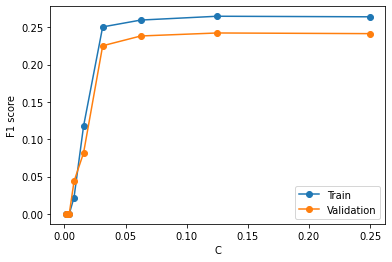

In [83]:
tune_model = Pipeline([
    ('Trans',transformer),
    ('Sampler',sampler),
    ('SVC', SVC(kernel='linear'))
])
train_result, val_result = [], []
tuned_C = [2**x for x in range(-10,-1,1)]
# Set the parameters
for c in tuned_C:
    tune_model['SVC'].set_params(C=c)
    cv_results = cross_validate(tune_model, X_train, y_train, cv = kfold, scoring=scoring, return_train_score=True)
    train_result.append(cv_results['train_score'].mean())
    val_result.append(cv_results['test_score'].mean())
my_lineplot(tuned_C, [train_result,val_result],['Train','Validation'],'C','F1 score')

`C` = $$2^{-3}$$ is the best value for linear kernel
### Compare the result of linear kernel and RBF kernel with tuned parameters

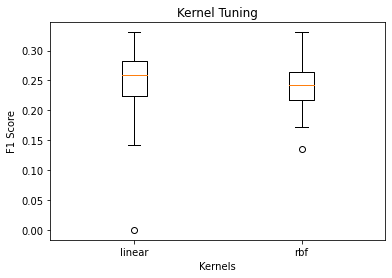

In [76]:
results = {'linear':[], 'rbf':[]}
for _ in range(50):
    for kernel in results:
        kernel_model = Pipeline([('Trans',transformer),
                                 ('Sampler',RandomUnderSampler(sampling_strategy=0.4)),
                                 ('SVC',SVC(kernel=kernel))
                                 ])
        if kernel == 'linear':
            kernel_model['SVC'].set_params(C=0.125)
        elif kernel == 'rbf':
            kernel_model['SVC'].set_params(C=1,gamma=0.125)
        cv_results = cross_val_score(kernel_model, X_train, y_train, cv=kfold, scoring=scoring)
        results[kernel].extend(cv_results)
my_boxplot(list(results.values()),list(results.keys()),"Kernels", "F1 Score", "Kernel Tuning")

## 4. Evaluation
Predict and evaluate the accuracy on test data

[[1382  222]
 [  35   47]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1604
           1       0.17      0.57      0.27        82

    accuracy                           0.85      1686
   macro avg       0.58      0.72      0.59      1686
weighted avg       0.94      0.85      0.88      1686



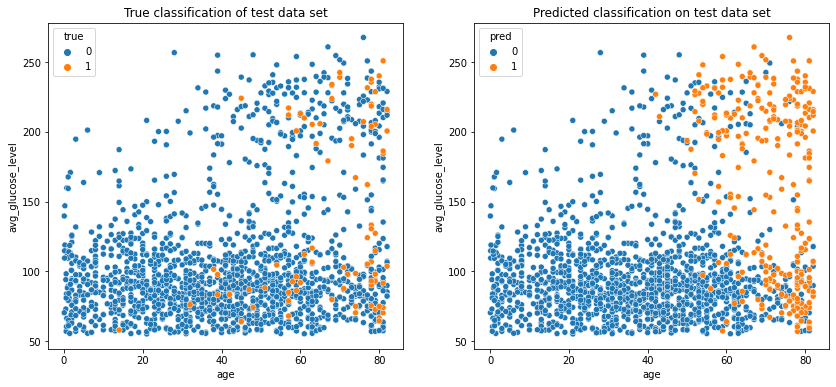

In [130]:
svc = Pipeline([('Trans', transformer),
                  ('Sampler',RandomUnderSampler(sampling_strategy=0.4)),
                  ('SVC',SVC(kernel='rbf',C=1,gamma=0.125))
                 ])
svc.fit(X_train,y_train)

y_predict = svc.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))

test_data = X_test.copy()
test_data['true'] = y_test
test_data['pred'] = y_predict
test_data.sort_values('true', inplace=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='true')
plt.title('True classification of test data set')

test_data.sort_values('pred', inplace=True)
plt.subplot(1, 2, 2)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='pred')
plt.title('Predicted classification on test data set')
title = "CART_final_prediction"
plt.show()

[[1439  165]
 [  40   42]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1604
           1       0.20      0.51      0.29        82

    accuracy                           0.88      1686
   macro avg       0.59      0.70      0.61      1686
weighted avg       0.94      0.88      0.90      1686



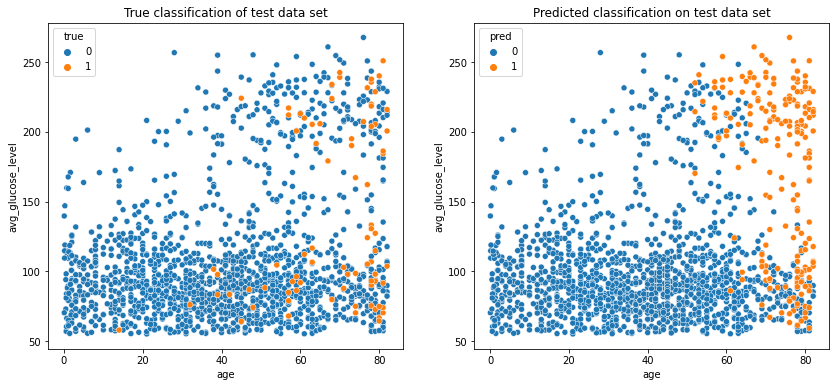

In [131]:
svc = Pipeline([('Trans', transformer),
                ('Sampler',RandomUnderSampler(sampling_strategy=0.4)),
                ('SVC',SVC(kernel='linear',C=0.125))
                ])
svc.fit(X_train,y_train)

y_predict = svc.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
test_data = X_test.copy()
test_data['true'] = y_test
test_data['pred'] = y_predict
test_data.sort_values('true', inplace=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='true')
plt.title('True classification of test data set')

test_data.sort_values('pred', inplace=True)
plt.subplot(1, 2, 2)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='pred')
plt.title('Predicted classification on test data set')
title = "CART_final_prediction"
plt.show()